# 1. Introduction and Setup

## Customer Personality Analysis

This is a simple practice on cleaning and analyzing data. This dataset is from Kaggle (https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis?resource=download)

### Relevant Information
#### Context
##### Problem Statement

Customer Personality Analysis is a detailed analysis of a company’s ideal customers. It helps a business to better understand its customers and makes it easier for them to modify products according to the specific needs, behaviors and concerns of different types of customers.

Customer personality analysis helps a business to modify its product based on its target customers from different types of customer segments. For example, instead of spending money to market a new product to every customer in the company’s database, a company can analyze which customer segment is most likely to buy the product and then market the product only on that particular segment.

#### Content
##### Attributes

###### People

- ID: Customer's unique identifier
- Year_Birth: Customer's birth year
- Education: Customer's education level
- Marital_Status: Customer's marital status
- Income: Customer's yearly household income
- Kidhome: Number of children in customer's household
- Teenhome: Number of teenagers in customer's household
- Dt_Customer: Date of customer's enrollment with the company
- Recency: Number of days since customer's last purchase
- Complain: 1 if the customer complained in the last 2 years, 0 otherwise

###### Products

- MntWines: Amount spent on wine in last 2 years
- MntFruits: Amount spent on fruits in last 2 years
- MntMeatProducts: Amount spent on meat in last 2 years
- MntFishProducts: Amount spent on fish in last 2 years
- MntSweetProducts: Amount spent on sweets in last 2 years
- MntGoldProds: Amount spent on gold in last 2 years

###### Promotion

- NumDealsPurchases: Number of purchases made with a discount
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

###### Place

- NumWebPurchases: Number of purchases made through the company’s website
- NumCatalogPurchases: Number of purchases made using a catalogue
- NumStorePurchases: Number of purchases made directly in stores
- NumWebVisitsMonth: Number of visits to company’s website in the last month

## Library Imports and Configuration

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

In [57]:
import pandas as pd

# Auxiliary function to calculate the upper and lower limits
def calculate_limits(df, column, threshold=1.5):
    Q1 = df[column].quantile(0.25)  # First quartile
    Q3 = df[column].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile range
    
    # Calculate the lower and upper limits
    lower_limit = Q1 - threshold * IQR
    upper_limit = Q3 + threshold * IQR
    
    return lower_limit, upper_limit

# Function to detect and count outliers
def detect_outliers(df, threshold=1.5):
    outliers_count = {}

    # Loop through columns, excluding binary columns (0 and 1 values)
    for column in df.columns:
        if df[column].dtype in ['object'] or df[column].nunique() == 2:  # Exclude binary columns (0, 1)
            continue
        
        if df[column].dtype in ['float64', 'int64']:  # Numeric columns
            lower_limit, upper_limit = calculate_limits(df, column, threshold)
            
            # Count the outliers
            outliers = ((df[column] < lower_limit) | (df[column] > upper_limit)).sum()
            outliers_count[column] = outliers

    # Return a DataFrame with the outlier count
    outliers_df = pd.DataFrame(list(outliers_count.items()), columns=['Column', 'Outliers Count'])
    return outliers_df

# Function to cap the outliers by replacing them with the upper or lower limits
def cap_outliers(df, threshold=1.5):
    for column in df.columns:
        if df[column].dtype in ['object'] or df[column].nunique() == 2:  # Exclude binary columns (0, 1)
            continue
        
        if df[column].dtype in ['float64', 'int64']:  # Numeric columns
            lower_limit, upper_limit = calculate_limits(df, column, threshold)
            
            # Apply the capping: replace values outside the limits
            df[column] = df[column].clip(lower=lower_limit, upper=upper_limit)
    
    return df


## Loading Data 

In [58]:
# load dataset
data = pd.read_csv('data/marketing_campaign.csv', sep='\t')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# 2. Exploratory Data Analysis

## Structural Inspection

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [60]:
data.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


In [61]:
data.isin([np.inf, -np.inf]).any()

ID                     False
Year_Birth             False
Education              False
Marital_Status         False
Income                 False
Kidhome                False
Teenhome               False
Dt_Customer            False
Recency                False
MntWines               False
MntFruits              False
MntMeatProducts        False
MntFishProducts        False
MntSweetProducts       False
MntGoldProds           False
NumDealsPurchases      False
NumWebPurchases        False
NumCatalogPurchases    False
NumStorePurchases      False
NumWebVisitsMonth      False
AcceptedCmp3           False
AcceptedCmp4           False
AcceptedCmp5           False
AcceptedCmp1           False
AcceptedCmp2           False
Complain               False
Z_CostContact          False
Z_Revenue              False
Response               False
dtype: bool

In [62]:
data.duplicated().any()

np.False_

In [63]:
# Convert Dt_Customer to datetime
type(data['Dt_Customer'][0])

str

In [64]:
# Check for outliers in numerical columns
detect_outliers(data)

,Column,Outliers Count
0,ID,0
1,Year_Birth,3
2,Income,8
3,Kidhome,0
4,Teenhome,0
5,Recency,0
6,MntWines,35
7,MntFruits,227
8,MntMeatProducts,175
9,MntFishProducts,223


### Income

In [65]:
data['Income'].describe()

count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: Income, dtype: float64

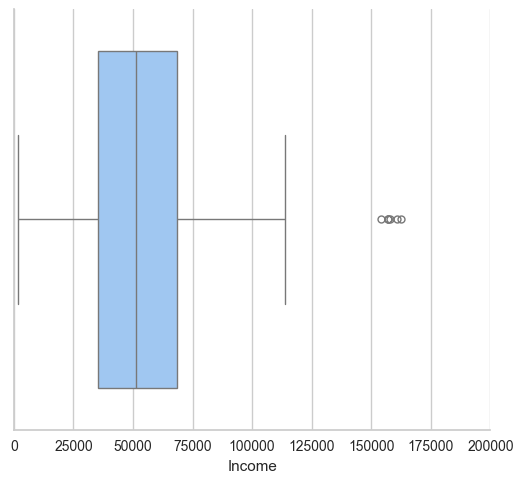

In [66]:
# Income distribution plot
plt.style.use('seaborn-v0_8-pastel')

sns.catplot(
    data=data,
    x='Income',
    kind='box'
)

plt.xlim(0, 200000) 

plt.show()

### Education and Marital Status

In [67]:
# Analyzing object type columns
for col in data.select_dtypes(include=['object']).columns:
    if col != 'Dt_Customer':
        print(f'{col}: {data[col].unique()}')

Education: ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Marital_Status: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


In [68]:
data['Education'].value_counts()

Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64

In [69]:
data['Marital_Status'].value_counts()

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

### Products

In [70]:
product_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 
                'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']


data_melt = data[product_cols].melt(
    var_name='Product', 
    value_name='Amount_Spent'
)

data_melt.head()

,Product,Amount_Spent
0,MntWines,635
1,MntWines,11
2,MntWines,426
3,MntWines,11
4,MntWines,173


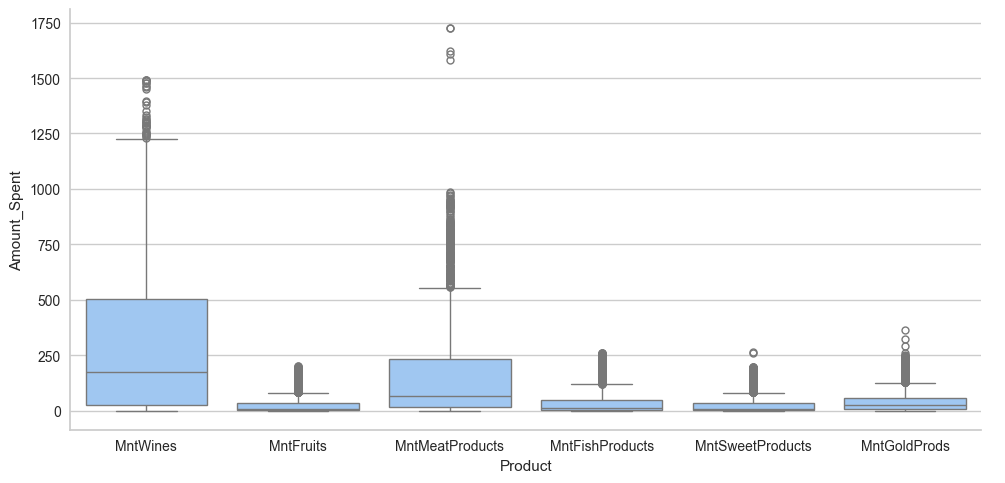

In [71]:
sns.catplot(
    data=data_melt,
    x='Product',
    y='Amount_Spent',
    kind='box',
    aspect=2
)

plt.show()

### Place

In [72]:
place_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

data_melt = data[place_cols].melt(
    var_name='Purchase_Place',
    value_name='Num_Purchases'
)

data_melt.head()

,Purchase_Place,Num_Purchases
0,NumWebPurchases,8
1,NumWebPurchases,1
2,NumWebPurchases,8
3,NumWebPurchases,2
4,NumWebPurchases,5


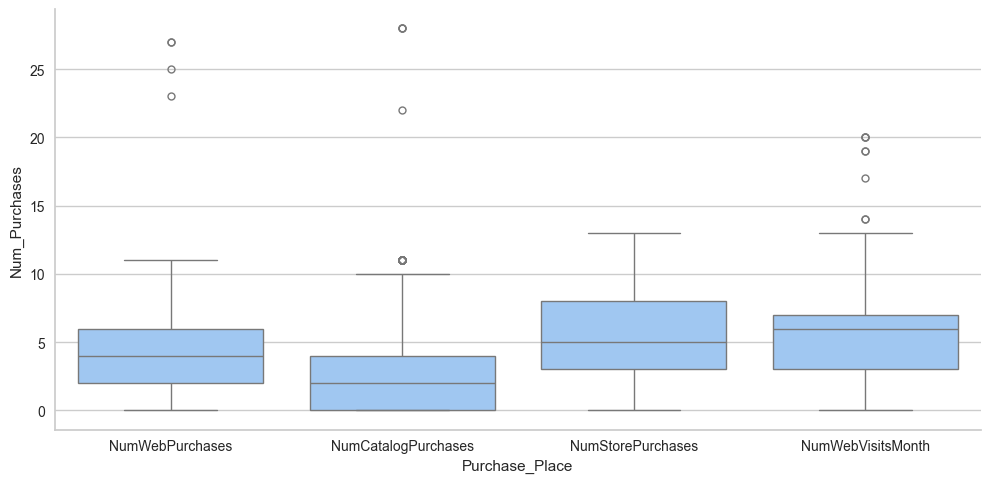

In [73]:
sns.catplot(
    data=data_melt,
    x='Purchase_Place',
    y='Num_Purchases',
    kind='box',
    aspect=2
)

# 3. Data Preprocessing and Feature Engineering

## **Basic Observations**

- **Dt_Customer** is currently a string; it should be converted to **datetime** format.
- **Income** has missing values that need to be handled.

### **Feature Engineering**

- **Categorical Variables**:

  - Both **Education** and **Marital_Status** contain some categories with small sample sizes and little impact. We will group them as follows:

    - **Education**: {"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"}
    - **Marital_Status**: {"Married": "In a Partnership", "Together": "In a Partnership", "Absurd": "Alone", "Widow": "Alone", "YOLO": "Alone", "Divorced": "Alone", "Single": "Alone"}
- **Transformations**:

  - Convert **Year_Birth** into **Age**.
  - Convert **Dt_Customer** into **Seniority** (time since becoming a customer).
- **New Features**:

  - Create a new variable, **NumChildren**, using the **KidHome** and **TeenHome** variables, but only for individuals who have a partner.
  - To improve **PCA**, create a binary variable, **Is_Parent**, which will indicate whether the individual has children or not.
  - Create a new variable, **AmountTotal**, as the sum of all amounts (e.g., **AmountSpent**, etc.).
- Based on the results from the outlier detection function and other analyses, we will handle the outliers by **applying capping**. This allows us to maintain the impact of extreme values that are not considered outliers.
- **Drop Redundant Features**: Remove any features that are highly correlated or redundant.

### **Data Preprocessing**


- For algorithms, we will need to convert **Education** and **Marital_Status** into appropriate formats.

- **Standardization**: Apply **standardization** to reduce the dominance of certain variables and to improve the overall distribution of the data.

- **Principal Component Analysis (PCA)**: Perform **PCA** to address **high correlation** between variables.



## Data Cleaning

### Deleting rows with None Values

This decision is based on the fact that Income is a fundamental feature, and the dataset only has 24 rows with missing values.

In [74]:
data.dropna(inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2216 non-null   int64  
 1   Year_Birth           2216 non-null   int64  
 2   Education            2216 non-null   object 
 3   Marital_Status       2216 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2216 non-null   int64  
 6   Teenhome             2216 non-null   int64  
 7   Dt_Customer          2216 non-null   object 
 8   Recency              2216 non-null   int64  
 9   MntWines             2216 non-null   int64  
 10  MntFruits            2216 non-null   int64  
 11  MntMeatProducts      2216 non-null   int64  
 12  MntFishProducts      2216 non-null   int64  
 13  MntSweetProducts     2216 non-null   int64  
 14  MntGoldProds         2216 non-null   int64  
 15  NumDealsPurchases    2216 non-null   int64 

### Converting Dt_Customer

In [75]:
cleaned_data = data.copy()
cleaned_data['Dt_Customer'] = pd.to_datetime(cleaned_data['Dt_Customer'], format='%d-%m-%Y')
cleaned_data['Dt_Customer'].head()

0   2012-09-04
1   2014-03-08
2   2013-08-21
3   2014-02-10
4   2014-01-19
Name: Dt_Customer, dtype: datetime64[ns]

## Feature Engineering

### Categorical Variables

In [76]:
cleaned_data['Education'] = cleaned_data['Education'].replace({"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"})
cleaned_data['Education'].value_counts()

Education
Graduate         1116
Postgraduate      846
Undergraduate     254
Name: count, dtype: int64

In [77]:
cleaned_data['Marital_Status'] = cleaned_data['Marital_Status'].replace({"Married": "In a Partnership", "Together": "In a Partnership", "Absurd": "Alone", "Widow": "Alone", "YOLO": "Alone", "Divorced": "Alone", "Single": "Alone"})
cleaned_data['Marital_Status'].value_counts()

Marital_Status
In a Partnership    1430
Alone                786
Name: count, dtype: int64

### Transformations

In [78]:
cleaned_data['Year_Birth'].head()

0    1957
1    1954
2    1965
3    1984
4    1981
Name: Year_Birth, dtype: int64

In [79]:
last_date = cleaned_data['Dt_Customer'].max()

In [80]:
cleaned_data['Age'] = last_date.year - cleaned_data['Year_Birth']
cleaned_data['Age'].head()

0    57
1    60
2    49
3    30
4    33
Name: Age, dtype: int64

In [81]:
cleaned_data['Seniority'] = (last_date - cleaned_data['Dt_Customer']).dt.days // 30
cleaned_data['Seniority'].head()

0    22
1     3
2    10
3     4
4     5
Name: Seniority, dtype: int64

### New Features

In [82]:
cleaned_data['NumChildren'] = cleaned_data['Kidhome'] + cleaned_data['Teenhome']
cleaned_data['NumChildren'].head()

0    0
1    2
2    0
3    1
4    1
Name: NumChildren, dtype: int64

In [83]:
cleaned_data['Is_Parent'] = np.where(cleaned_data['NumChildren'] > 0, 1, 0)
cleaned_data['Is_Parent'].head()

0    0
1    1
2    0
3    1
4    1
Name: Is_Parent, dtype: int64

In [84]:
cleaned_data['Amount_Total'] = cleaned_data[product_cols].sum(axis=1)
cleaned_data['Amount_Total'].head()

0    1617
1      27
2     776
3      53
4     422
Name: Amount_Total, dtype: int64

### Drop Redundant Features

In [85]:
cleaned_data.rename(columns={'MntWines': "Wines",'MntFruits':'Fruits','MntMeatProducts':'Meat','MntFishProducts':'Fish','MntSweetProducts':'Sweets','MntGoldProds':'Gold'}, inplace=True)

In [86]:
cleaned_data.drop(columns=['ID', 'Dt_Customer', 'Year_Birth', 'Z_CostContact', 'Z_Revenue'], inplace=True)

### Capping

In [87]:
cap_outliers(cleaned_data)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Seniority,NumChildren,Is_Parent,Amount_Total
0,Graduate,Alone,58138.0,0,0,58,635.0,79.5,546.0,120.5,...,0,0,0,0,1,57,22,0.0,0,1617.0
1,Graduate,Alone,46344.0,1,1,38,11.0,1.0,6.0,2.0,...,0,0,0,0,0,60,3,2.0,1,27.0
2,Graduate,In a Partnership,71613.0,0,0,26,426.0,49.0,127.0,111.0,...,0,0,0,0,0,49,10,0.0,0,776.0
3,Graduate,In a Partnership,26646.0,1,0,26,11.0,4.0,20.0,10.0,...,0,0,0,0,0,30,4,1.0,1,53.0
4,Postgraduate,In a Partnership,58293.0,1,0,94,173.0,43.0,118.0,46.0,...,0,0,0,0,0,33,5,1.0,1,422.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,Graduate,In a Partnership,61223.0,0,1,46,709.0,43.0,182.0,42.0,...,0,0,0,0,0,47,12,1.0,1,1341.0
2236,Postgraduate,In a Partnership,64014.0,2,1,56,406.0,0.0,30.0,0.0,...,0,1,0,0,0,68,0,2.5,1,444.0
2237,Graduate,Alone,56981.0,0,0,91,908.0,48.0,217.0,32.0,...,0,0,0,0,0,33,5,0.0,0,1241.0
2238,Postgraduate,In a Partnership,69245.0,0,1,8,428.0,30.0,214.0,80.0,...,0,0,0,0,0,58,5,1.0,1,843.0


In [88]:
detect_outliers(cleaned_data)

,Column,Outliers Count
0,Income,0
1,Kidhome,0
2,Teenhome,0
3,Recency,0
4,Wines,0
5,Fruits,0
6,Meat,0
7,Fish,0
8,Sweets,0
9,Gold,0


In [89]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   object 
 1   Marital_Status       2216 non-null   object 
 2   Income               2216 non-null   float64
 3   Kidhome              2216 non-null   int64  
 4   Teenhome             2216 non-null   int64  
 5   Recency              2216 non-null   int64  
 6   Wines                2216 non-null   float64
 7   Fruits               2216 non-null   float64
 8   Meat                 2216 non-null   float64
 9   Fish                 2216 non-null   float64
 10  Sweets               2216 non-null   int64  
 11  Gold                 2216 non-null   float64
 12  NumDealsPurchases    2216 non-null   int64  
 13  NumWebPurchases      2216 non-null   int64  
 14  NumCatalogPurchases  2216 non-null   int64  
 15  NumStorePurchases    2216 non-null   int64 

## Data Preprocessing

### Categorical Values Transformation

- "We only need to apply transformations to **Education** and **Marital_Status**. **Education** is an ordinal variable, while **Marital_Status** is nominal. Since we will be using PCA before our clustering algorithm, we can apply **OrdinalEncoding** to **Education** and **LabelEncoding** to **Marital_Status**.", due to it has just two categories


In [90]:
ordinal_encoder = OrdinalEncoder(categories=[['Undergraduate', 'Graduate', 'Postgraduate']])
cleaned_data['Education'] = ordinal_encoder.fit_transform(cleaned_data[['Education']])

In [91]:
cleaned_data['Education'].head()

0    1.0
1    1.0
2    1.0
3    1.0
4    2.0
Name: Education, dtype: float64

In [92]:
label_encoder = LabelEncoder()
cleaned_data['Marital_Status'] = label_encoder.fit_transform(cleaned_data['Marital_Status'])


In [93]:
cleaned_data['Marital_Status'].head()

0    0
1    0
2    1
3    1
4    1
Name: Marital_Status, dtype: int64

### StandarScaler

In [94]:
scaler = StandardScaler()

# Features on deals accepted and promotions
cols_exclude = ['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain', 'Response']

scaled_data = cleaned_data.copy()
scaled_data = scaled_data.drop(columns=cols_exclude)

scaled_array = scaler.fit_transform(scaled_data)

scaled_data = pd.DataFrame(
    scaled_array, 
    columns= scaled_data.columns, 
    index=scaled_data.index
)

In [95]:
scaled_data.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,...,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Seniority,NumChildren,Is_Parent,Amount_Total
0,-0.409776,-1.348829,0.297483,-0.823039,-0.928972,0.310532,0.999970,2.152157,2.205500,2.185805,...,0.510352,1.486473,2.692681,-0.554143,0.724129,1.008423,1.586267,-1.297843,-1.581389,1.675604
1,-0.409776,-1.348829,-0.262669,1.039938,0.909066,-0.380509,-0.881037,-0.764148,-0.811664,-0.747217,...,-0.140736,-1.159633,-0.596724,-1.169518,-0.128512,1.263348,-1.233942,1.475561,0.632356,-0.962396
2,-0.409776,0.741384,0.937474,-0.823039,-0.928972,-0.795134,0.369953,1.019070,-0.135596,1.950668,...,-0.791824,1.486473,-0.231235,1.291982,-0.554832,0.328625,-0.194918,-1.297843,-1.581389,0.280285
3,-0.409776,0.741384,-1.198219,1.039938,-0.928972,-0.795134,-0.881037,-0.652697,-0.733441,-0.549207,...,-0.140736,-0.781618,-0.962214,-0.554143,0.297809,-1.285895,-1.085510,0.088859,0.632356,-0.919259
4,1.124115,0.741384,0.304845,1.039938,-0.928972,1.554407,-0.392699,0.796168,-0.185882,0.341837,...,1.812527,0.352427,0.134255,0.061232,-0.128512,-1.030971,-0.937078,0.088859,0.632356,-0.307044


## Dimensionality Reduction

In [96]:
pca = PCA(n_components=3)
pca_results = pca.fit_transform(scaled_data)

In [97]:
pca_results

array([[ 5.25171556,  0.22085572,  2.33975663],
       [-3.04585899,  0.07866612, -1.75146873],
       [ 2.83040736, -1.00263337,  0.10646562],
       ...,
       [ 2.37664386, -1.62492673,  0.07716147],
       [ 2.07013658,  1.45107426, -1.89061161],
       [-2.49337452,  1.69027295, -0.57916105]])

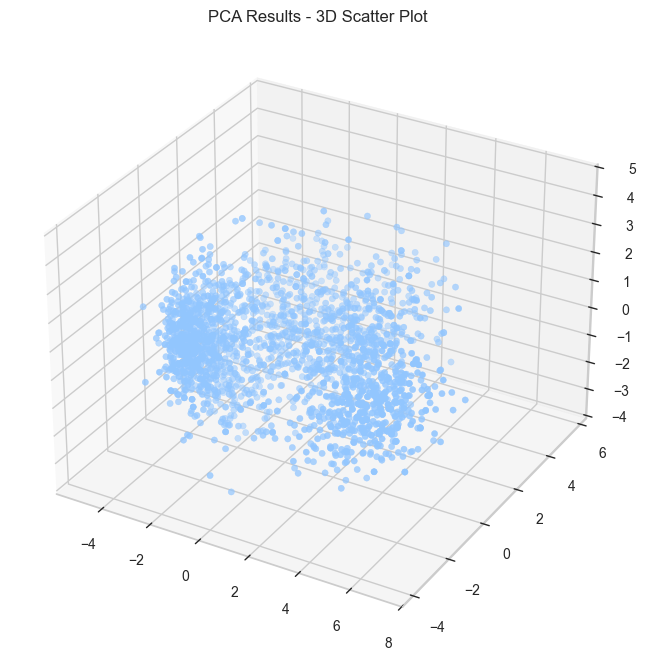

In [98]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    pca_results[:, 0], 
    pca_results[:, 1], 
    pca_results[:, 2],
    marker='o', 
)

ax.set_title('PCA Results - 3D Scatter Plot')
plt.show()

# 4. Modeling and Evaluation

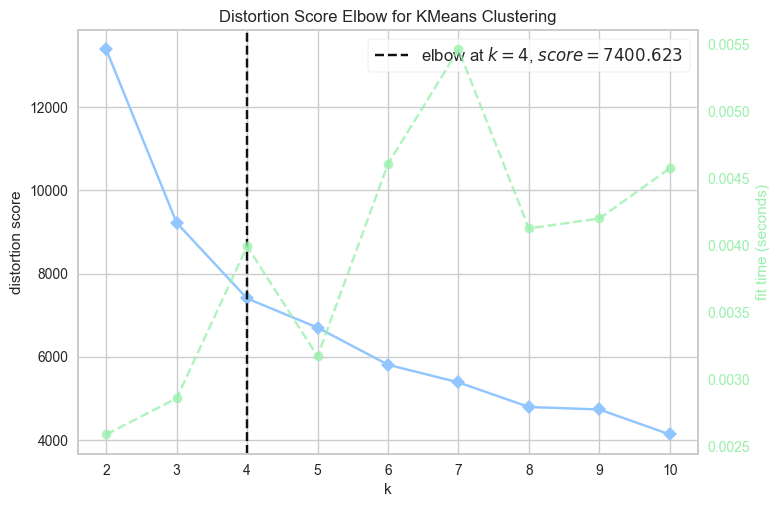

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [99]:
# Determine the optimal number of clusters using the Elbow Method
ElBow_M = KElbowVisualizer(KMeans(), k=10)
ElBow_M.fit(pca_results)
ElBow_M.show()


In [100]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_clusters = kmeans.fit_predict(pca_results)
kmeans_clusters

array([2, 3, 2, ..., 2, 1, 3], dtype=int32)

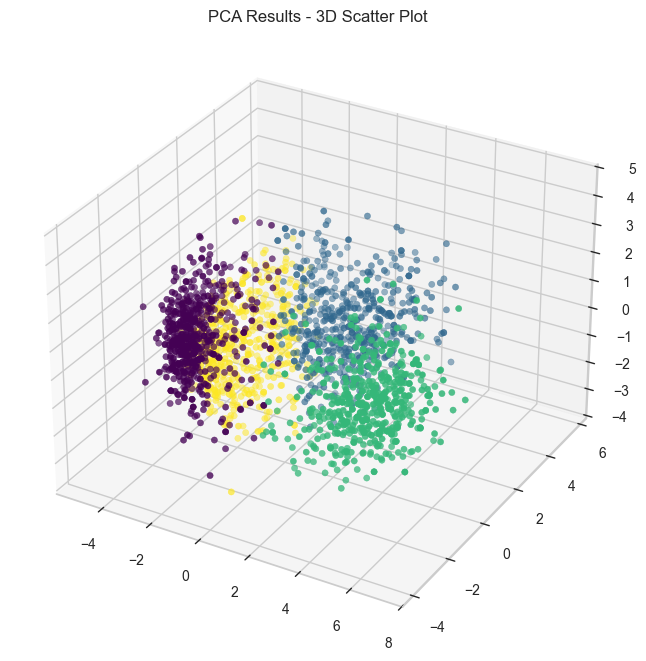

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    pca_results[:, 0], 
    pca_results[:, 1], 
    pca_results[:, 2],
    c=kmeans_clusters,
    cmap='viridis',
    marker='o', 
)

ax.set_title('Cluster Results - 3D Scatter Plot')
plt.show()

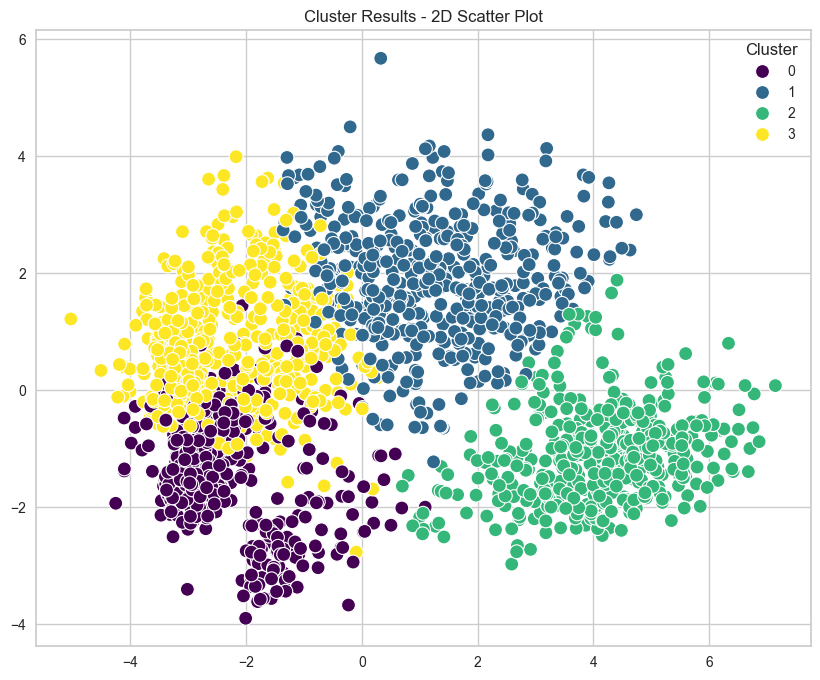

In [107]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x=pca_results[:, 0], y=pca_results[:, 1],
    hue=kmeans_clusters,
    palette='viridis',
    s=100
)

plt.title('Cluster Results - 2D Scatter Plot')
plt.legend(title='Cluster')
plt.grid(True)

plt.show()

# 5. Interpretation and Conclusion

In [102]:
# Análisis de clusters para determinar estrategias
cluster_info = pd.DataFrame({
    'Cluster': kmeans_clusters,
    'Age': cleaned_data['Age'],
    'Income': cleaned_data['Income'],
    'Is_Parent': cleaned_data['Is_Parent'],
    'Amount_Wine': cleaned_data['Wines'],
    'Amount_Fruits': cleaned_data['Fruits'],
    'Amount_Meat': cleaned_data['Meat'],
    'Amount_Fish': cleaned_data['Fish'],
    'Amount_Sweets': cleaned_data['Sweets'],
    'Amount_Gold': cleaned_data['Gold'],
})

# Descripción de cada cluster
for cluster in cluster_info['Cluster'].unique():
    cluster_data = cluster_info[cluster_info['Cluster'] == cluster]
    print(f'Cluester {cluster}:')
    print(f' - Age Average: {cluster_data['Age'].mean():.0f}')
    print(f' - Income Average: {cluster_data['Income'].mean():.2f}')
    print(f' - Parent Percentage: {cluster_data['Is_Parent'].mean() * 100:.2f}%')
    print(f' - Amount of Wine Average: {cluster_data['Amount_Wine'].mean():.2f}')
    print(f' - Amount of Fruits Average: {cluster_data['Amount_Fruits'].mean():.2f}')
    print(f' - Amount of Meat Average: {cluster_data['Amount_Meat'].mean():.2f}')
    print(f' - Amount of Fish Average: {cluster_data['Amount_Fish'].mean():.2f}')
    print(f' - Amount of Sweets Average: {cluster_data['Amount_Sweets'].mean():.2f}')
    print(f' - Amount of Gold Average: {cluster_data['Amount_Gold'].mean():.2f}')

Cluester 2:
 - Age Average: 46
 - Income Average: 75816.42
 - Parent Percentage: 4.31%
 - Amount of Wine Average: 598.87
 - Amount of Fruits Average: 49.37
 - Amount of Meat Average: 401.80
 - Amount of Fish Average: 77.93
 - Amount of Sweets Average: 50.68
 - Amount of Gold Average: 64.32
Cluester 3:
 - Age Average: 50
 - Income Average: 44219.18
 - Parent Percentage: 99.15%
 - Amount of Wine Average: 110.77
 - Amount of Fruits Average: 4.25
 - Amount of Meat Average: 33.08
 - Amount of Fish Average: 5.99
 - Amount of Sweets Average: 4.09
 - Amount of Gold Average: 17.82
Cluester 0:
 - Age Average: 37
 - Income Average: 29305.59
 - Parent Percentage: 79.01%
 - Amount of Wine Average: 27.91
 - Amount of Fruits Average: 6.10
 - Amount of Meat Average: 24.08
 - Amount of Fish Average: 9.30
 - Amount of Sweets Average: 6.41
 - Amount of Gold Average: 16.51
Cluester 1:
 - Age Average: 48
 - Income Average: 62311.52
 - Parent Percentage: 96.79%
 - Amount of Wine Average: 537.59
 - Amount of

In [103]:
from sklearn import metrics


print("Shiloutte: ", metrics.silhouette_score(pca_results, kmeans_clusters, sample_size=2000))

Shiloutte:  0.36353781111655453
